In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score , confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# !pip install geoplot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- - - - - - - - - - - -

__Getting Data Loaded__

NOTE: the original data has a line with encoding errors, so this was removed prior to loading it into this notebook.



In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data_Mining_Project_Group16/crime_rem141.csv', encoding='utf_8', engine='python', index_col=0)
df.head(10)

,offense_id,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC,VICTIM_COUNT
incident_id,,,,,,,,,,,,,,,,,,,
20226000193,20226000193299900,2999,0,criminal-mischief-other,public-disorder,1/4/2022 11:30:00 AM,1/4/2022 12:00:00 PM,1/4/2022 8:36:00 PM,128 S CANOSA CT,3135366.0,1685410.0,-105.018825,39.714268,4.0,411.0,valverde,1,0,1
20223319,20223319299900,2999,0,criminal-mischief-other,public-disorder,1/3/2022 6:45:00 AM,NaN,1/3/2022 11:01:00 AM,650 15TH ST,3142454.0,1696151.0,-104.993418,39.743649,6.0,611.0,cbd,1,0,1
20223093,20223093299900,2999,0,criminal-mischief-other,public-disorder,1/3/2022 1:00:00 AM,NaN,1/3/2022 6:11:00 AM,919 E COLFAX AVE,3147484.0,1694898.0,-104.975557,39.740130,6.0,621.0,north-capitol-hill,1,0,1
20224000,20224000299900,2999,0,criminal-mischief-other,public-disorder,1/3/2022 7:47:00 PM,NaN,1/3/2022 9:12:00 PM,2345 W ALAMEDA AVE,3136478.0,1684414.0,-105.014892,39.711518,4.0,411.0,valverde,1,0,1
20223956,20223956299900,2999,0,criminal-mischief-other,public-disorder,1/3/2022 5:06:00 PM,NaN,1/3/2022 8:31:00 PM,7800 E SMITH RD,3169237.0,1705800.0,-104.897950,39.769688,5.0,512.0,central-park,1,0,1
20223903,20223903299900,2999,0,criminal-mischief-other,public-disorder,1/3/2022 4:40:00 PM,NaN,1/3/2022 7:07:00 PM,857 E COLFAX AVE,3147195.0,1695029.0,-104.976582,39.740495,6.0,621.0,north-capitol-hill,1,0,1
20223899,20223899299900,2999,0,criminal-mischief-other,public-disorder,1/3/2022 4:19:00 PM,NaN,1/3/2022 4:21:00 PM,1501 S COLORADO BLVD,3157325.0,1676368.0,-104.940969,39.689101,3.0,312.0,cory-merrill,1,0,1
20223888,20223888299900,2999,0,criminal-mischief-other,public-disorder,1/3/2022 4:15:00 PM,NaN,1/3/2022 11:05:00 PM,1133 N LINCOLN ST,3144418.0,1692850.0,-104.986500,39.734556,6.0,623.0,capitol-hill,1,0,1
20228085,20228085299900,2999,0,criminal-mischief-other,public-disorder,1/5/2022 7:00:00 PM,1/6/2022 7:00:00 AM,1/6/2022 9:03:00 AM,2500 E CHERRY CREEK S DR,3152806.0,1685804.0,-104.956826,39.715080,3.0,311.0,belcaro,1,0,1


---

**Cleaning and Processing Data**

- remove ID columns
- keep only "FIRST_OCCURENCE_DATE"
- split date and time into separate columns

In [ ]:
# columns to keep:
# 'incident_id', 'OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID', 'FIRST_OCCURRENCE_DATE', 'DISTRICT_ID',	'PRECINCT_ID', 'IS_CRIME',	'IS_TRAFFIC',	'VICTIM_COUNT'
#   _, 3,4,13,14,16,17,18

dateTimeSeries = pd.Series(data=df.iloc[:,5])

monthList = []
yearList = []
hourList = []

for date in dateTimeSeries:
    splt = date.split()
    if len(splt) > 3:
        print("Somethin weird")
    dsplt = splt[0].split('/')    # should be [month,day,year]
    tsplt = splt[1].split(':')      # [hour,minute,second]
    monthList.append(int(dsplt[0]))
    yearList.append(int(dsplt[2]) - 2017)  # normalize to 0,1,2,3,4,5 instead of full year
    if splt[2] == 'AM':
        hourList.append(int(tsplt[0]))
    else:
        hourList.append(int(tsplt[0]) + 12)

subset = df.iloc[:,[3,4,13,14,16,17,18]]      # [['incident_id', 'OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID', 'DISTRICT_ID', 'PRECINCT_ID', 'IS_CRIME', 'IS_TRAFFIC', 'VICTIM_COUNT']]
# subset.shape        # = (376811, 7)

subset = subset.assign(Month = pd.Series(data=monthList).values)
subset = subset.assign(Year = pd.Series(data=yearList).values)
subset = subset.assign(Hour = pd.Series(data=hourList).values)

subset


,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,DISTRICT_ID,PRECINCT_ID,IS_CRIME,IS_TRAFFIC,VICTIM_COUNT,Month,Year,Hour
incident_id,,,,,,,,,,
20226000193,criminal-mischief-other,public-disorder,4.0,411.0,1,0,1,1,5,11
20223319,criminal-mischief-other,public-disorder,6.0,611.0,1,0,1,1,5,6
20223093,criminal-mischief-other,public-disorder,6.0,621.0,1,0,1,1,5,1
20224000,criminal-mischief-other,public-disorder,4.0,411.0,1,0,1,1,5,19
20223956,criminal-mischief-other,public-disorder,5.0,512.0,1,0,1,1,5,17
...,...,...,...,...,...,...,...,...,...,...
20228028363,theft-fail-return-rent-veh,white-collar-crime,7.0,759.0,1,0,1,5,5,24
2022330642,fraud-by-telephone,white-collar-crime,5.0,522.0,1,0,1,6,5,14
2022328815,fraud-by-use-of-computer,white-collar-crime,3.0,313.0,1,0,1,6,5,18


---

***Plots to gain insight***

In [ ]:
#describeing the statistical characteristics of numerical attributes
subset.describe()

,DISTRICT_ID,PRECINCT_ID,IS_CRIME,IS_TRAFFIC,VICTIM_COUNT,Month,Year,Hour
count,376227.000000,376227.000000,376811.0,376811.0,376811.000000,376811.000000,376811.000000,376811.000000
mean,3.653199,383.203882,1.0,0.0,1.020156,6.278930,2.408263,14.334337
std,1.790020,179.980649,0.0,0.0,0.226457,3.376172,1.627524,6.525955
min,1.000000,111.000000,1.0,0.0,1.000000,1.000000,0.000000,1.000000
25%,2.000000,222.000000,1.0,0.0,1.000000,3.000000,1.000000,10.000000
50%,3.000000,324.000000,1.0,0.0,1.000000,6.000000,2.000000,15.000000
75%,5.000000,523.000000,1.0,0.0,1.000000,9.000000,4.000000,20.000000
max,7.000000,759.000000,1.0,0.0,32.000000,12.000000,5.000000,24.000000


In [ ]:
#describing statistical characteristics of all types of variables:
subset.describe(include='all')

,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,DISTRICT_ID,PRECINCT_ID,IS_CRIME,IS_TRAFFIC,VICTIM_COUNT,Month,Year,Hour
count,376811,376811,376227.000000,376227.000000,376811.0,376811.0,376811.000000,376811.000000,376811.000000,376811.000000
unique,195,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,theft-of-motor-vehicle,public-disorder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,44530,55684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,3.653199,383.203882,1.0,0.0,1.020156,6.278930,2.408263,14.334337
std,NaN,NaN,1.790020,179.980649,0.0,0.0,0.226457,3.376172,1.627524,6.525955
min,NaN,NaN,1.000000,111.000000,1.0,0.0,1.000000,1.000000,0.000000,1.000000
25%,NaN,NaN,2.000000,222.000000,1.0,0.0,1.000000,3.000000,1.000000,10.000000
50%,NaN,NaN,3.000000,324.000000,1.0,0.0,1.000000,6.000000,2.000000,15.000000
75%,NaN,NaN,5.000000,523.000000,1.0,0.0,1.000000,9.000000,4.000000,20.000000


In [ ]:
 # attempting to find outliers 

min_=subset.Month.min()
max_=subset.Month.max()
q1=subset.Month.quantile(0.25)
q2=subset.Month.quantile(0.5)
q3=subset.Month.quantile(0.75)
iqr=q3-q1

lower_cutoff = q1 - 1.5*iqr
upper_cutoff = q3 + 1.5*iqr

print(f'lower cutoff: {lower_cutoff}  upper cutoff: {upper_cutoff}')
print( "min = " , min_ ,", max = " , max_ ,", lc = " , lower_cutoff ,", uc = " , upper_cutoff)

subset.Month.plot(kind="box", title='box plot for month')

In [ ]:
min_=subset.VICTIM_COUNT.min()
max_=subset.VICTIM_COUNT.max()
q1=subset.VICTIM_COUNT.quantile(0.25)
q2=subset.VICTIM_COUNT.quantile(0.5)
q3=subset.VICTIM_COUNT.quantile(0.75)
iqr=q3-q1

lower_cutoff = q1 - 1.5*iqr
upper_cutoff = q3 + 1.5*iqr

print(f'lower cutoff: {lower_cutoff}  upper cutoff: {upper_cutoff}')
print( "min = " , min_ ,", max = " , max_ ,", lc = " , lower_cutoff ,", uc = " , upper_cutoff)

subset.VICTIM_COUNT.plot(kind="box", title='box plot for VICTIM_COUNT')

In [ ]:
plt.plot(subset['Hour'].value_counts())
plt.xlabel('time in hours [Hrs]')
plt.ylabel('# of crimes')
plt.title('#of crimes at particular time(hrs)')
 #$subset['Hour'].value_counts()

In [ ]:
plt.plot(subset['Year'].value_counts())
plt.xlabel('year')
plt.ylabel('# of crimes')
plt.title('#of crimes over 5 years (2017-2022)')

In [ ]:
 \section{Milestones}subset.plot(x='VICTIM_COUNT',y='OFFENSE_CATEGORY_ID',kind = 'scatter')
 plt.show()

In [ ]:
# # Unique Offence_type_IDs types
import random
offence_ids = df['OFFENSE_CATEGORY_ID'].unique()

colors = ["#" + ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
for i in range(len(offence_ids))]
patches, texts = plt.pie(df['OFFENSE_CATEGORY_ID'].value_counts(),
  colors=colors,
  startangle=90,
  labels=offence_ids)
labels = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(offence_ids,
100.*df['OFFENSE_CATEGORY_ID'].value_counts()/df['OFFENSE_CATEGORY_ID'].value_counts().sum())]
plt.legend(patches, labels, loc='upper right', bbox_to_anchor=(-0.35, .5), fontsize=10)
plt.xticks(rotation=60, ha='right')
plt.show()

In [ ]:
offCat = pd.unique(df['OFFENSE_CATEGORY_ID'])
offCount = dict.fromkeys(offCat, 0);
for entry in df['OFFENSE_CATEGORY_ID']:
     offCount[entry] += 1
fig = plt.figure(figsize = (10,5))
plt.bar(offCat, list(offCount.values()))
plt.xlabel("Category of crime")
plt.ylabel("# of cases")
plt.title("Total number of each category of criminal offense")
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
offType = pd.unique(df['OFFENSE_TYPE_ID'])
offTypeCount = dict.fromkeys(offType, 0);
for entry in df['OFFENSE_TYPE_ID']:
    offTypeCount[entry] += 1
plotTypes = []
plotVals = []
for i in range(len(offType)):
    if offTypeCount[offType[i]] >= 15000:       ## Only the most frequent types of offenses (there are a lot in total)
        plotTypes.append(offType[i])
        plotVals.append(offTypeCount[offType[i]])
fig = plt.figure(figsize = (20,5))
plt.bar(plotTypes, plotVals)
plt.xlabel("Type of crime")
plt.ylabel("# of cases")
plt.title("Total number of each type of criminal offense")
plt.show()

In [ ]:
 precinctID = pd.unique(df['PRECINCT_ID'])
 offPreCount = dict.fromkeys(precinctID, 0);
 for entry in df['PRECINCT_ID']:
     if entry > 0:                       ## PRECINCT_ID contains NaN 
         offPreCount[entry] += 1
 fig = plt.figure(figsize = (15,5))
 plt.bar(precinctID, list(offPreCount.values()))
 plt.xlabel("ID of precinct")
 plt.ylabel("# of cases")
 plt.title("Number of criminal offenses for each precinct")
 plt.show()

In [ ]:
monthNums = pd.unique(subset['Month'])
offMonthCount = dict.fromkeys(monthNums, 0);
for entry in subset['Month']:
    offMonthCount[entry] += 1
fig = plt.figure(figsize = (15,5))
plt.bar(monthNums, list(offMonthCount.values()), color='red')
plt.xlabel("Month")
plt.ylabel("# of cases")
plt.title("Total number of criminal offenses per month")
plt.show()

In [ ]:
yearNums = pd.unique(subset['Year'])
offYearCount = dict.fromkeys(yearNums, 0);
for entry in subset['Year']:
    offYearCount[entry] += 1
fig = plt.figure(figsize = (15,5))
plt.bar(yearNums, list(offYearCount.values()),color='green')
plt.xlabel("Year")
plt.ylabel("# of cases")
plt.title("Total number of criminal offenses per Year")
plt.show()

**classification algos**

In [ ]:
subset['OFFENSE_CATEGORY_ID'].unique()

array(['public-disorder', 'drug-alcohol', 'sexual-assault',
       'all-other-crimes', 'robbery', 'other-crimes-against-persons',
       'aggravated-assault', 'arson', 'burglary', 'larceny',
       'theft-from-motor-vehicle', 'auto-theft', 'white-collar-crime',
       'murder'], dtype=object)

In [ ]:
#splitting target and examples from dataframe
subset_x=subset.drop(['OFFENSE_CATEGORY_ID','OFFENSE_TYPE_ID'], axis=1)
subset_y=subset['OFFENSE_CATEGORY_ID']

#filling missing data(NAN) with 0 

subset_x=subset_x.fillna(0)
subset_y=subset_y.fillna(0)
print(np.shape(subset_y))
np.shape(subset_x)

(376811,)


(376811, 8)

In [ ]:
#train test split (80/20)
x_train,x_test,y_train,y_test=train_test_split(subset_x,subset_y,test_size=0.20)

**Decision Tree**

In [ ]:
#decision tree implementation with entropy 
Dt=DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_leaf=14)
Dt.fit(x_train.values,y_train.values)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=14)

In [ ]:
y_pred=Dt.predict(x_test.values)
print(("Accuracy for this decision tree with entropy as a measure to split is : "), accuracy_score(y_test,y_pred)*100)
print('\n')
print(('report for entropy based decision tree: \n'),classification_report(y_test, y_pred))

Accuracy for this decision tree with entropy as a measure to split is :  21.426960179398378




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report for entropy based decision tree: 
                               precision    recall  f1-score   support

          aggravated-assault       0.29      0.13      0.18      3239
            all-other-crimes       0.24      0.38      0.30     11038
                       arson       0.00      0.00      0.00       165
                  auto-theft       0.20      0.26      0.23      9149
                    burglary       0.13      0.08      0.10      5169
                drug-alcohol       0.23      0.20      0.22      4879
                     larceny       0.24      0.31      0.27     10768
                      murder       0.00      0.00      0.00        81
other-crimes-against-persons       0.16      0.05      0.08      4953
             public-disorder       0.18      0.16      0.17     11223
                     robbery       0.00      0.00      0.00      1389
              sexual-assault       0.00      0.00      0.00       931
    theft-from-motor-vehicle       0.20      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


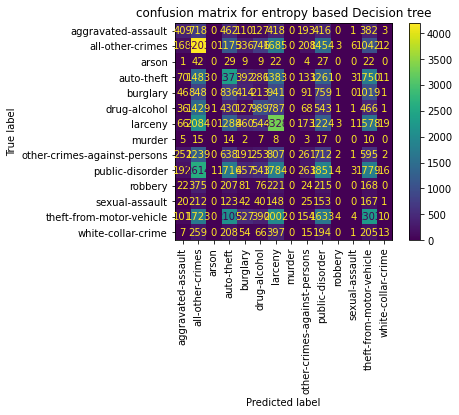

In [ ]:
plot_confusion_matrix(Dt, x_test, y_test) 
plt.title('confusion matrix for entropy based Decision tree') 
plt.xticks(rotation=90)
plt.show()

In [ ]:
#DT with Gini index
Dt_gini=DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_leaf=14)
Dt_gini.fit(x_train.values,y_train.values)

DecisionTreeClassifier(min_samples_leaf=14)

In [ ]:
y_pred_gini=Dt_gini.predict(x_test.values)
print(("Accuracy for this decision tree with gini as a measure to split is : "), accuracy_score(y_test,y_pred_gini)*100)
print('\n')
print(('report for gini based decision tree: \n'),classification_report(y_test, y_pred_gini))

Accuracy for this decision tree with gini as a measure to split is :  21.55699746559983




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


report for gini based decision tree: 
                               precision    recall  f1-score   support

          aggravated-assault       0.28      0.12      0.17      3239
            all-other-crimes       0.24      0.37      0.30     11038
                       arson       0.00      0.00      0.00       165
                  auto-theft       0.22      0.27      0.24      9149
                    burglary       0.14      0.08      0.10      5169
                drug-alcohol       0.24      0.21      0.22      4879
                     larceny       0.24      0.30      0.27     10768
                      murder       0.00      0.00      0.00        81
other-crimes-against-persons       0.16      0.06      0.08      4953
             public-disorder       0.17      0.17      0.17     11223
                     robbery       0.00      0.00      0.00      1389
              sexual-assault       0.00      0.00      0.00       931
    theft-from-motor-vehicle       0.20      0.21 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


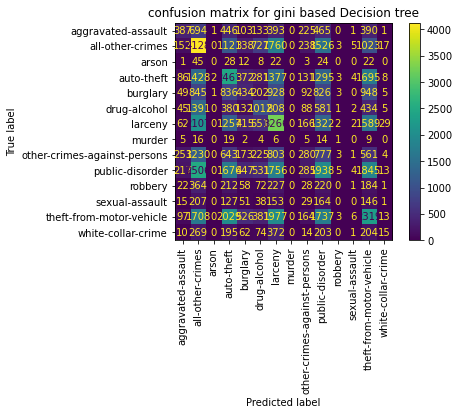

In [ ]:
plot_confusion_matrix(Dt_gini, x_test, y_test) 
plt.title('confusion matrix for gini based Decision tree') 
plt.xticks(rotation=90)
plt.show()

**KNN classifier**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)

X_train = scaler.transform(x_train)
X_test = scaler.transform(x_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier_knn = KNeighborsClassifier(n_neighbors=5)
classifier_knn.fit(x_train, y_train)

y_pred_knn = classifier_knn.predict(x_test)
print(classification_report(y_test, y_pred_knn))

                              precision    recall  f1-score   support

          aggravated-assault       0.07      0.13      0.09      3239
            all-other-crimes       0.22      0.36      0.27     11038
                       arson       0.01      0.01      0.01       165
                  auto-theft       0.18      0.23      0.20      9149
                    burglary       0.11      0.08      0.09      5169
                drug-alcohol       0.20      0.17      0.18      4879
                     larceny       0.22      0.22      0.22     10768
                      murder       0.00      0.00      0.00        81
other-crimes-against-persons       0.09      0.04      0.05      4953
             public-disorder       0.17      0.14      0.15     11223
                     robbery       0.01      0.00      0.00      1389
              sexual-assault       0.01      0.00      0.00       931
    theft-from-motor-vehicle       0.20      0.15      0.17     10960
          white-col

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


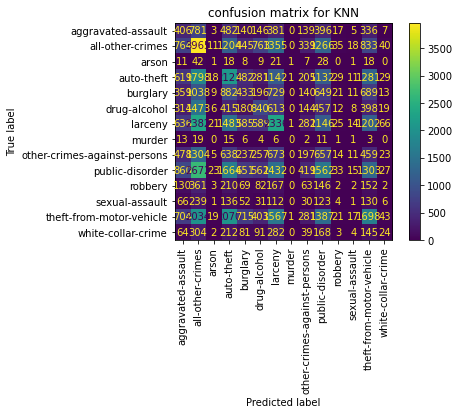

In [ ]:
plot_confusion_matrix(classifier_knn, x_test, y_test) 
plt.title('confusion matrix for KNN') 
plt.xticks(rotation=90)
plt.show()

**Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier_RF = RandomForestClassifier(max_depth=2, random_state=0)
classifier_RF.fit(x_train, y_train)
y_pred_RF = classifier_RF.predict(X_test)

print(classification_report(y_test, y_pred_RF))
 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              precision    recall  f1-score   support

          aggravated-assault       0.50      0.15      0.23      3239
            all-other-crimes       0.00      0.00      0.00     11038
                       arson       0.00      0.00      0.00       165
                  auto-theft       0.00      0.00      0.00      9149
                    burglary       0.00      0.00      0.00      5169
                drug-alcohol       0.00      0.00      0.00      4879
                     larceny       0.00      0.00      0.00     10768
                      murder       0.00      0.00      0.00        81
other-crimes-against-persons       0.00      0.00      0.00      4953
             public-disorder       0.15      0.99      0.26     11223
                     robbery       0.00      0.00      0.00      1389
              sexual-assault       0.00      0.00      0.00       931
    theft-from-motor-vehicle       0.00      0.00      0.00     10960
          white-col

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


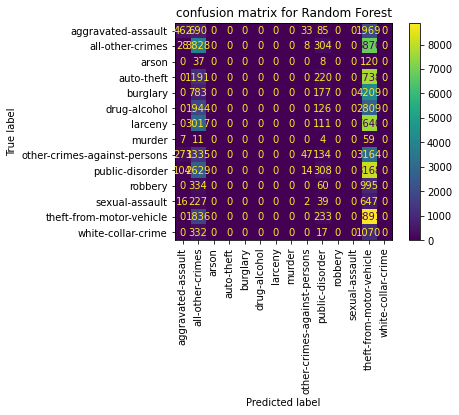

In [ ]:
plot_confusion_matrix(classifier_RF, x_test, y_test) 
plt.title('confusion matrix for Random Forest') 
plt.xticks(rotation=90)
plt.show()

---

***Apriori Algorithm***

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Data_Mining_Project_Group16/crime_rem141.csv', encoding='utf_8', engine='python', index_col=0)
df.shape

24
6


In [ ]:
dateTimeSeries = pd.Series(data=df.iloc[:,5])

monthList = []
yearList = []
hourList = []

for date in dateTimeSeries:
    splt = date.split()
    if len(splt) > 3:
        print("Somethin weird")
    dsplt = splt[0].split('/')    # should be [month,day,year]
    tsplt = splt[1].split(':')      # [hour,minute,second]
    monthList.append(int(dsplt[0]))
    yearList.append(int(dsplt[2]) - 2017)  # normalize to 0,1,2,3,4,5 instead of full year
    if splt[2] == 'AM':
        hourList.append(int(tsplt[0]))
    else:
        hourList.append(int(tsplt[0]) + 12)
subset = df.iloc[:,[3,4,13,14,16]]#,17,18]]      # [['incident_id', 'OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID', 'DISTRICT_ID', 'PRECINCT_ID', 'IS_CRIME', 'IS_TRAFFIC', 'VICTIM_COUNT']]
subset = subset.assign(Month = pd.Series(data=monthList).values)
subset = subset.assign(Year = pd.Series(data=yearList).values)
subset = subset.assign(Hour = pd.Series(data=hourList).values)
subset.head()

In [ ]:
subset.replace([np.inf, -np.inf], np.nan, inplace=True)
subset.dropna(subset=["PRECINCT_ID", "DISTRICT_ID"], how="all", inplace=True)
subset.shape

In [ ]:
singleListNames = np.concatenate((subset['OFFENSE_TYPE_ID'].unique() 
    , subset['OFFENSE_CATEGORY_ID'].unique() 
    , np.array([str(x) for x in subset['DISTRICT_ID'].unique()]) 
    , [str(x) for x in subset['PRECINCT_ID'].unique()] 
    , [str(x) for x in subset['Month'].unique()]
    , [str(x) for x in subset['Year'].unique()]
    , [str(x) for x in subset['Hour'].unique()]))

sert = pd.Series([int(0) for _ in range(subset.shape[0])])
df_apriori = pd.concat([sert for _ in range(len(singleListNames))], axis=1)
df_apriori.columns = singleListNames
# print("Shape of dataframe:")
# print(df_apriori.shape)
# print()
# print("0%")
originalCols = ['OFFENSE_TYPE_ID','OFFENSE_CATEGORY_ID','DISTRICT_ID','PRECINCT_ID','Month','Year','Hour']
counter = 0
for index, row in subset.iterrows():
    for co in originalCols:
        df_apriori.at[counter, str(row[co])] = int(1)
    # if counter%50000 == 0:
    #     print(counter)
    counter += 1
# print("Done")

In [ ]:
## save new database as .csv
df_apriori.to_csv('apriori-data.csv')
## describe data
df_apriori.describe()

In [ ]:
## Running Apriori now

!pip install mlxtend     # download apriori package
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules   # import apriori method

dfa = pd.read_csv('apriori-data.csv', encoding='utf_8', engine='python', index_col=0)   # read in apriori itemset data

dfa.replace([np.nan, -np.nan], False, inplace=True)    # formatting needs everything to be boolean
dfa.replace(0, False, inplace=True)
dfa.replace(1, True, inplace=True)
dfa.head()

In [ ]:
frq_items = apriori(dfa, min_support = 0.001, use_colnames = True)     ## run apriori method

rules = association_rules(frq_items, metric = 'lift', min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending = [False, False])      ## extract association rules
print(rules.head())     # print rules

In [ ]:
print(frq_items)

---

# Clustering

***K Means on Time***

In [ ]:
## 1D K Means

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

df = pd.read_csv('crime_rem141.csv', encoding='utf_8', engine='python', index_col=0)
df.shape

dateTimeSeries = pd.Series(data=df.iloc[:,5])

monthList = []
yearList = []
hourList = []

for date in dateTimeSeries:
    splt = date.split()
    if len(splt) > 3:
        print("Somethin weird")
    dsplt = splt[0].split('/')    # should be [month,day,year]
    tsplt = splt[1].split(':')      # [hour,minute,second]
    monthList.append(int(dsplt[0]))
    yearList.append(int(dsplt[2]) - 2017)  # normalize to 0,1,2,3,4,5 instead of full year
    if splt[2] == 'AM':
        hourList.append(int(tsplt[0]))
    else:
        hourList.append(int(tsplt[0]) + 12)
subset = df.iloc[:,[3,4,13,14,16]]#,17,18]]      # [['incident_id', 'OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID', 'DISTRICT_ID', 'PRECINCT_ID', 'IS_CRIME', 'IS_TRAFFIC', 'VICTIM_COUNT']]
subset = subset.assign(Month = pd.Series(data=monthList).values)
subset = subset.assign(Year = pd.Series(data=yearList).values)
subset = subset.assign(Hour = pd.Series(data=hourList).values)

subset.replace([np.inf, -np.inf], np.nan, inplace=True)
subset.dropna(subset=["Month", "Year", "Hour"], how="all", inplace=True)
subset.shape

subset.head()

In [ ]:
k = 3
col = 'Hour'   ## change to attribute of focus: 'Hour', 'Month', 'Year'

kmeans = KMeans(n_clusters=k)
subset[str('label_'+str(k))] = kmeans.fit_predict(subset[[col]])
ax = subset[subset[str('label_'+str(k))]==0].plot.scatter(x=col, 
                                                      y=str('label_'+str(k)), 
                                                      color='white', 
                                                      edgecolor='black')
subset[subset[str('label_'+str(k))]==1].plot.scatter(x=col, 
                                                 y=str('label_'+str(k)), 
                                                 s=50, color='white', 
                                                 ax=ax, edgecolor='red')
subset[subset[str('label_'+str(k))]==2].plot.scatter(x=col, 
                                                 y=str('label_'+str(k)), 
                                                 s=50, color='white', 
                                                 ax=ax, edgecolor='blue')
# subset[subset[str('label_'+str(k))]==3].plot.scatter(x=col, 
#                                                  y=str('label_'+str(k)), 
#                                                  s=50, color='white', 
#                                                  ax=ax, edgecolor='orange')
# subset[subset[str('label_'+str(k))]==4].plot.scatter(x=col, 
#                                                  y=str('label_'+str(k)), 
#                                                  s=50, color='white', 
#                                                  ax=ax, edgecolor='purple')
# subset[subset[str('label_'+str(k))]==5].plot.scatter(x=col, 
#                                                  y=str('label_'+str(k)), 
#                                                  s=50, color='white', 
#                                                  ax=ax, edgecolor='yellow')
plt.scatter(kmeans.cluster_centers_.ravel(), 
            [0.5]*len(kmeans.cluster_centers_), 
            s=100, color='green', marker='*')

***K Means on location***

In [ ]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv

df = pd.read_csv('/content/drive/MyDrive/Data_Mining_Project_Group16/crime_rem141.csv', encoding='utf_8', engine='python', index_col=0)
cluster_sub = df[['offense_id','GEO_LON','GEO_LAT']]
cluster_sub.dropna(subset=["GEO_LON", "GEO_LAT"], how="all", inplace=True)
cluster_sub.head()

In [ ]:
## calculate score for a range of k values
kDifClusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in kDifClusters]
yax = cluster_sub[['GEO_LON']]
xax = cluster_sub[['GEO_LAT']]
score = [kmeans[i].fit(yax).score(yax) for i in range(len(kmeans))]

In [ ]:
## plot k scores
plt.plot(kDifClusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [ ]:
## run k means on 3 clusters
kmeans = KMeans(n_clusters = 3, init = 'k-means++')
kmeans.fit(cluster_sub[cluster_sub.columns[1:3]])

In [ ]:
## calculate kmeans labels and centers
cluster_sub['cluster_label'] = kmeans.fit_predict(cluster_sub[cluster_sub.columns[1:3]])

centers = kmeans.cluster_centers_

labels = kmeans.predict(cluster_sub[cluster_sub.columns[1:3]])

cluster_sub.head(10)

In [ ]:
## plot clusters
cluster_sub.plot.scatter(x = 'Longitude', y = 'Latitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)

In [ ]:
## add labels back to original database
cluster_sub = cluster_sub[['offense_id','cluster_label']]
clustered_data = df.merge(cluster_sub, left_on='offense_id', right_on='offense_id')
clustered_data.head()

In [ ]:
## save data as csv
clustered_data.to_csv('kmeans_clustered_data.csv', header=True)

***GMM***

In [ ]:
import pandas as pd          # data manipulation
import numpy as np           #  ^
from sklearn.mixture import GaussianMixture  # GMM clustering
from sklearn import metrics                  # Silhouette score
import matplotlib.pyplot as plt       # data visualization
import plotly.express as px           #  ^
import plotly.graph_objects as go     #  ^

## read in data
dfg = pd.read_csv('/content/drive/MyDrive/Data_Mining_Project_Group16/crime_rem141.csv', encoding='utf_8', engine='python', index_col=0)
cluster_sub = dfg[['offense_id','GEO_LON','GEO_LAT']]
cluster_sub.dropna(subset=["GEO_LON", "GEO_LAT"], how="all", inplace=True)      # clean coordinate columns of nans
cluster_sub.head()

In [ ]:
## plot geo coords and zoom into denver area
fig = go.Figure(data=go.Scattergeo(
    lat=cluster_sub['GEO_LAT'],
    lon=cluster_sub['GEO_LON'],
    mode = 'markers',
    marker_color = 'black',
))

fig.update_layout(
    width=980,
    height=720,
    margin={"r":0,"t":10,"l":0,"b":10},
    geo = dict(
        scope='world',
        projection_type='miller',
        landcolor = 'rgb(250,250,250)',
        center=dict(lat=39.742043,lon=-104.991531),
        projection_scale=500),
)
fig.show()

In [ ]:
score = []   # save silhouette score here

ks = range(2,11)    # range of k values to try

x = df[['GEO_LAT','GEO_LON']]   # data subset

for cl in ks:
    model = GaussianMixture(n_components=cl, n_init=20, init_params='kmeans')
    labels = model.fit_predict(x)
    score.append(metrics.silhouette_score(x, labels, metric='euclidean'))

plt.figure(figsize=(16,8), dpi=300)     # plot the scores
plt.plot(ks,score, 'bo-', color='black')
plt.xlable('k')
plt.ylabel('Silhouette Score')

In [ ]:
## create model using 6 clusters
model6 = GaussianMixture(n_components=6,
                        covariance_type='full',
                        max_iter=100,
                        n_init=1,
                        init_params='kmeans',
                        verbose=0,
                        random_state=1
                        )
clust6 = model6.fit(x)
labels6 = model6.predict(x)

smpl=model6.sample(n_samples=10000)     # random sample of points using the model6 clusters

print(' 6 clusters ')
print('Means: ' , clust6.means_)        # print some of their information
print('Converged: ', clust6.converged_)
print('# of Iterations: ', clust6.n_iter_)

In [ ]:
# add the labels to the data set
dfg['Clust6']=labels6

# Create a plot
fig = go.Figure(data=go.Scattergeo(
        lat=dfg['GEO_LAT'],
        lon=dfg['GEO_LON'],
        hovertext=dfg['Clust6'], 
        mode = 'markers',
        marker=dict(colorscale=['#ae34eb', 'red', 'blue', '#34eb34']),  #color
        marker_color = dfg['Clust6'],
        ))
# zoom in on denver
fig.update_layout(
    showlegend=False,
    width=980,
    height=720,
    margin={"r":0,"t":30,"l":0,"b":10},
    geo = dict(
        scope='world',
        projection_type='miller',
        landcolor = "rgb(250, 250, 250)",
        center=dict(lat=39.742043,lon=-104.991531), # focus point
        projection_scale=500 # zoom in on
    ),
)
fig.show()

In [ ]:
# make another plot for the random sample of points
fig = go.Figure(data=go.Scattergeo(
        lat=smpl[0][:,0],
        lon=smpl[0][:,1],
        mode = 'markers',
        marker=dict(colorscale=['#ae34eb', 'red', 'blue', '#34eb34']),
        marker_color = smpl[1],
        marker_size=3
        ))

fig.update_layout(
        showlegend=False,
        width=980,
        height=720,
        margin={"r":0,"t":30,"l":0,"b":10},
        geo = dict(
            scope='world',
            projection_type='miller',
            landcolor = "rgb(250, 250, 250)",
            center=dict(lat=39.742043,lon=-104.991531), # focus point
            projection_scale=500 # zoom in on
        ),
    )
fig.show()